---
# Projeto 03 - Redes Neurais - Flags
---

## Etapa 1: Importação das Bibliotecas

In [1]:
#region Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sympy.physics.vector.printing import params
%matplotlib inline

# ---
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
except:
    !pip install skorch

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

# ---
from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings("ignore")
#endregion

In [2]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    import sys

    sys.path.append("/content/drive/MyDrive/modulos")
except:
    print("Você está off-line")

Você está off-line


In [3]:
#region Extras
import importlib

# import modulos.estrategia1
# import modulos.estrategia2
# import modulos.estrategia3
#
# importlib.reload(modulos.estrategia1)
# importlib.reload(modulos.estrategia2)
# importlib.reload(modulos.estrategia3)

#from modulos.estrategia1 import *
try:
    from modulos.estrategia1 import *
    from modulos.estrategia2 import *
    from modulos.estrategia3 import *
except:
    # Importar os módulos
    from estrategia1 import *
    from estrategia2 import *
    from estrategia3 import *
#endregion

## Etapa 2: Carregando os Dados

In [4]:
#region Nome das Colunas
colunas = [
    "name",
    "landmass",
    "zone",
    "area",
    "population",
    "language",
    "religion",
    "bars",
    "stripes",
    "colours",
    "red",
    "green",
    "blue",
    "gold",
    "white",
    "black",
    "orange",
    "mainhue",
    "circles",
    "crosses",
    "saltires",
    "quarters",
    "sunstars",
    "crescent",
    "triangle",
    "icon",
    "animate",
    "text",
    "topleft",
    "botright",
]
#endregion

In [5]:
#region Carregando o Dataset
try:
    flags = pd.read_csv("dataset/flag.data", header=None, names=colunas)
except:
    # URL do dataset no UCI Machine Learning Repository
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data"

    # Nome do arquivo que será salvo
    file_path = "flag.data"

    # Fazer o download do arquivo, se ele não existir
    if not os.path.exists(file_path):
        print("Baixando o dataset...")
        # Usar !wget para baixar o dataset diretamente no Colab
        !wget -O flag.data $url
        print("Download concluído!")
    flags = pd.read_csv("flag.data", header=None, names=colunas)
#endregion

In [6]:
flags.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


## Etapa 3: Pré-processamento

In [7]:
flags.describe()

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,...,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,...,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,3.572165,2.211340,700.046392,23.268041,5.340206,2.190722,0.453608,1.551546,3.463918,0.788660,...,0.170103,0.149485,0.092784,0.149485,1.386598,0.056701,0.139175,0.252577,0.201031,0.082474
std,1.553018,1.308274,2170.927932,91.934085,3.496517,2.061167,1.038339,2.328005,1.300154,0.409315,...,0.463075,0.385387,0.290879,0.435860,4.396186,0.231869,0.347025,0.435615,0.401808,0.275798
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,471.250000,14.000000,9.000000,4.000000,0.000000,3.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,0.000000,0.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,7.000000,5.000000,14.000000,8.000000,1.000000,...,4.000000,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000




```
# Isto está formatado como código
```

### Valores Ausentes

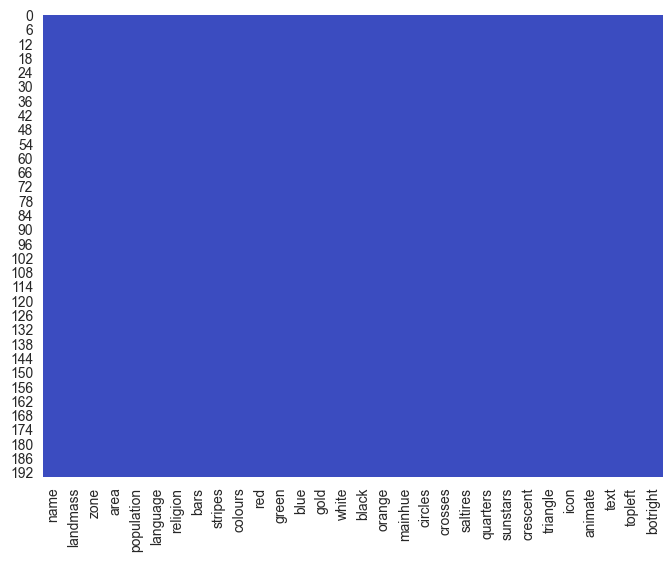

In [8]:
plt.figure(figsize=(8, 6), dpi=100)

sns.heatmap(flags.isna(), cbar=False, cmap="coolwarm");

In [9]:
calcPercentualValoresAusentes(flags)

O dataset tem 0.0 % de valores ausentes.


### Checando Valores Iguais a Zero (Área e População)

In [10]:
# Selecionando apenas os dados numéricos
cols = ["area", "population"]

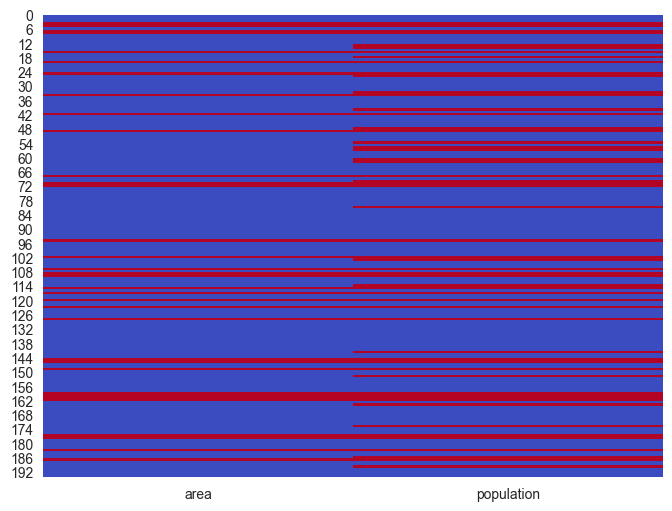

In [11]:
plt.figure(figsize=(8, 6), dpi=100)

sns.heatmap(flags[cols] < 1, cbar=False, cmap="coolwarm");

In [12]:
#region Verificar quais colunas tem valores menor ou igual a 0 (zero)
def checkZeroValues(df, cols):
    colsZero = (df[cols] <= 0).any()
    zeroCounts = (df[cols] <= 0).sum()
    zeroPercentages = round((df[cols] == 0).mean() * 100, 2)

    print("Soma de valores zero em cada coluna:")
    print(zeroCounts[zeroCounts > 0])

    print("\nPercentual de valores zero em cada coluna:")
    print(zeroPercentages[zeroPercentages > 0])

#endregion

In [13]:
checkZeroValues(flags, cols)

Soma de valores zero em cada coluna:
area          34
population    56
dtype: int64

Percentual de valores zero em cada coluna:
area          17.53
population    28.87
dtype: float64


### Conversão para Category

In [14]:
# Converter colunas categóricas para o tipo 'category'
categoricalCols = ["landmass", "zone", "language", "religion"]
flags[categoricalCols] = flags[categoricalCols].astype("category")

In [15]:
flags.select_dtypes(include="category").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   landmass  194 non-null    category
 1   zone      194 non-null    category
 2   language  194 non-null    category
 3   religion  194 non-null    category
dtypes: category(4)
memory usage: 2.0 KB


### Encoding

In [16]:
colsEncode = ["mainhue", "topleft", "botright"]

In [17]:
#region Encoding com OneHotEncoder
def encodeOneHot(df, cols):
    encoderOneHot = OneHotEncoder(sparse_output=False, drop="first")
    encodedCols = encoderOneHot.fit_transform(flags[cols])

    encodedDf = pd.DataFrame(encodedCols, columns=encoderOneHot.get_feature_names_out(cols))
    df = df.join(encodedDf)
    df.replace({pd.NA: 0., np.nan: 0.}, inplace=True)

    # Exclusão das colunas originais após a codificação.
    df = df.drop(columns=cols, axis=1)

    return df

#endregion

In [18]:
#region Encoding com LabelEncoder
def encodeLabel(df, cols):
    encoderLabel = LabelEncoder()
    for col in cols:
        df[col] = encoderLabel.fit_transform(df[col]) + 1

    return df

#endregion

In [19]:
flags = encodeOneHot(flags, colsEncode)

In [20]:
# Mover a coluna 'religion' a última posição
religion = flags.pop("religion")
flags["religion"] = religion

### Dropando Colunas

>  A maioria das análises de correlação, agrupamento e visualização não necessita dos nomes dos países, pois esses dados são independentes de um identificador textual específico. Portanto, a coluna "name" será removida do conjunto de dados.

In [21]:
# flags = flags.drop(columns="name", axis=1)

In [22]:
# Marxismo é uma ideologia política e socioeconômica baseada nas ideias de Karl Marx.
flags = flags[flags['religion'] != 6]
# Atualizar o valor que representa a religião 'Others'
flags["religion"] = flags["religion"].replace(7, 6)

### Salva uma cópia do Dataset (flags)

In [23]:
flags.to_csv("dataset/flags_tratado1.csv", index=False)

### Agrupamento das Colunas

#### Religiões

* 0 = Catholic
* 1 = Other Christian
* 2 = Muslim
* 3 = Buddhist **
* 4 = Hindu **
* 5 = Ethnic
* s/n = Marxist (Eliminada)
* 6 = Others

In [440]:
flags["religion"].value_counts()

religion
1    60
0    40
2    36
5    27
3     8
4     4
6     4
Name: count, dtype: int64

In [441]:
#region Mapeamentos para os rótulos de religiões
flags["religion"] = flags["religion"].replace([3, 4], 6)

religionMapping = {5: 3, 6: 4}

flags["religion"] = flags["religion"].replace(religionMapping)

flags = flags.sort_values(by="religion").reset_index(drop=True)
#endregion

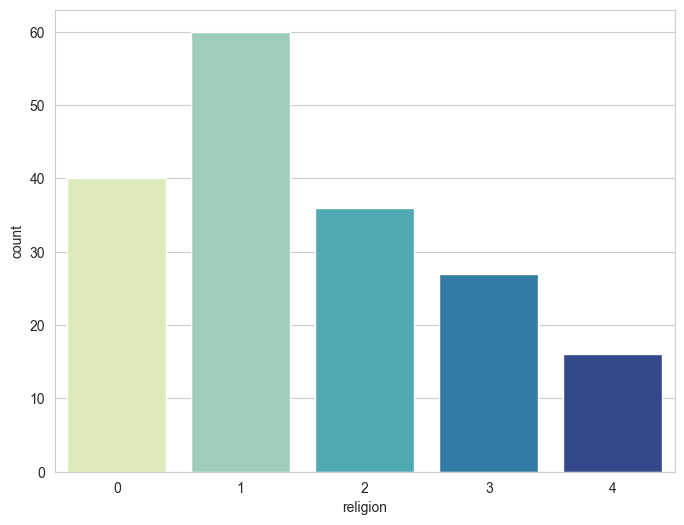

In [442]:
plt.figure(figsize=(8, 6), dpi=100)

sns.countplot(x="religion", data=flags, hue=None, palette="YlGnBu");

In [443]:
print(flags["religion"].value_counts())

religion
1    60
0    40
2    36
3    27
4    16
Name: count, dtype: int64


#### Linguagens

* 1: "English",
* 2: "Spanish",
* 3: "French",
* 4: "German",
* 5: "Slavic",
* 6: "Other Indo-European",
* 7: "Chinese",
* 8: "Arabic",
* 9: "Japanese/Turkish/Finnish/Magyar",
* 10: "Others"

In [444]:
flags["language"].value_counts()

language
1     43
10    42
6     27
2     20
8     19
3     17
4      5
7      3
9      3
5      0
Name: count, dtype: int64

In [445]:
#region Mapeamentos para os rótulos de linguagens
flags["language"] = flags["language"].replace([7, 9], 10)

flags["language"] = flags["language"].replace([4, 5], 6)

languageMapping = {6: 4, 8: 5, 10: 6}

flags["language"] = flags["language"].replace(languageMapping)

flags = flags.sort_values(by="language").reset_index(drop=True)
#endregion

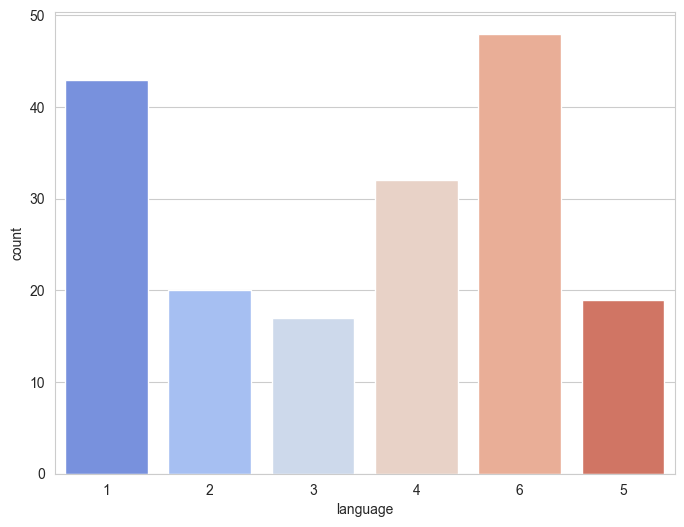

In [446]:
plt.figure(figsize=(8, 6), dpi=100)

sns.countplot(x="language", data=flags, hue=None, palette="coolwarm");

In [447]:
print(flags["language"].value_counts())

language
6    48
1    43
4    32
2    20
5    19
3    17
Name: count, dtype: int64


### Mapa de Correlação (Spearman)

In [448]:
spearman = flags[flags.columns].corr(method="spearman")["religion"].sort_values(ascending=False)
# print(spearman)

### Insights

In [449]:
#region Mapeamentos para os rótulos de religiões, continentes e linguagens
landmassLabels = {
    1: "N. America",
    2: "S. America",
    3: "Europe",
    4: "Africa",
    5: "Asia",
    6: "Oceania"
}

religionLabels = {
    0: "Catholic",
    1: "Other Christian",
    2: "Muslim",
    3: "Ethnic",
    4: "Others"
}

languageLabels = {
    1: "English",
    2: "Spanish",
    3: "French",
    4: "Other Indo-European",
    5: "Arabic",
    6: "Others"
}

colors = ["red", "green", "blue", "white", "black", "gold", "orange", "brown"]
#endregion

> **Distribuição por Continente:** A visualização mostra a distribuição de religiões por continente, revelando possíveis concentrações de certas religiões em regiões específicas.

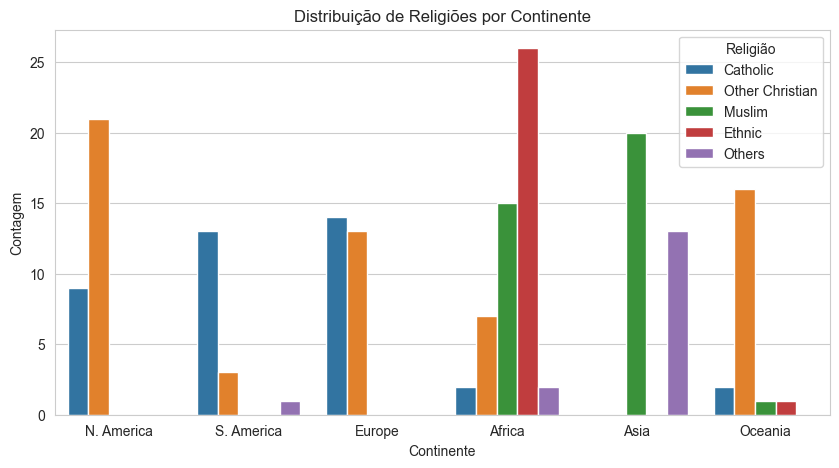

In [450]:
#region 1. Análise de distribuição da religião por continente

# Plot da distribuição de religiões por continente
plt.figure(figsize=(10, 5), dpi=100)
ax = sns.countplot(data=flags, x="landmass", hue="religion", palette="tab10")

# Renomear os valores do eixo x e a legenda
ax.set_xticklabels([landmassLabels[int(label.get_text())] for label in ax.get_xticklabels()])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [religionLabels[int(label)] for label in labels], title="Religião")

# Títulos e rótulos
plt.title("Distribuição de Religiões por Continente")
plt.xlabel("Continente")
plt.ylabel("Contagem")
plt.show()
#endregion

> **Proporção de Presença de Cores em Bandeiras por Religião:** O gráfico de calor mostra a proporção de presença de cores em bandeiras por religião, destacando as cores mais comuns em cada religião.

In [451]:
contagem = flags.groupby(["landmass", "religion"]).size().reset_index(name="count")
# contagem

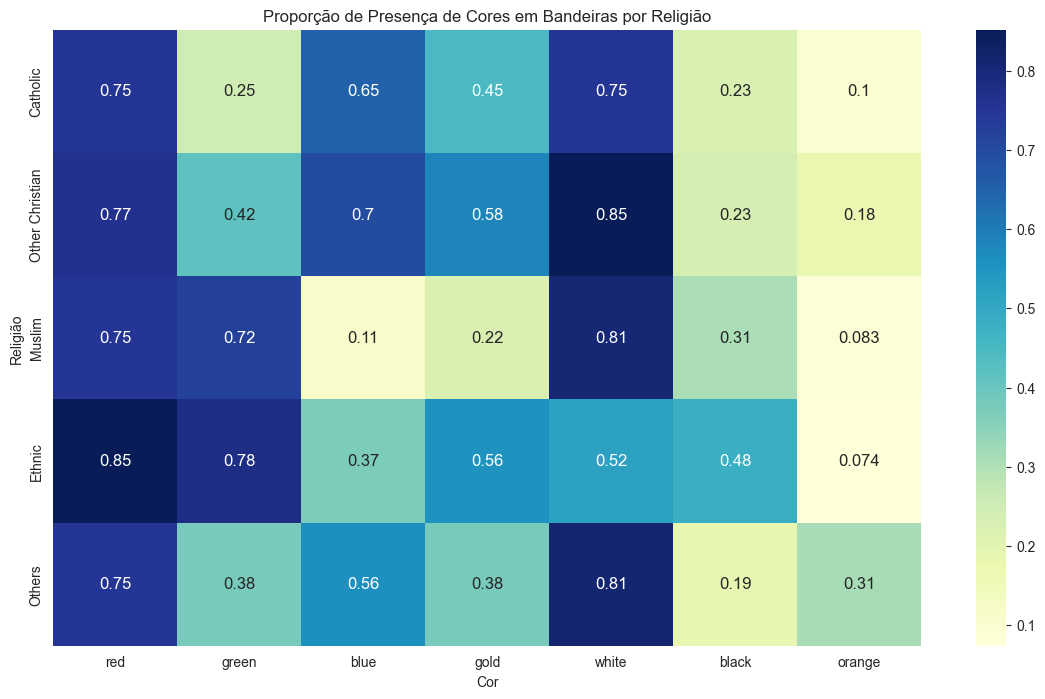

In [452]:
#region 2. Análise do uso de cores em bandeiras por religião
colors = ["red", "green", "blue", "gold", "white", "black", "orange"]
flagsColors = flags[colors + ["religion"]].groupby("religion").mean()

plt.figure(figsize=(14, 8), dpi=100)
sns.heatmap(
    flagsColors,
    annot=True,
    cmap="YlGnBu",
    cbar=True,
    yticklabels=[religionLabels.get(religion, religion) for religion in flagsColors.index],
    annot_kws={"size": 12}
)

plt.title("Proporção de Presença de Cores em Bandeiras por Religião")
plt.xlabel("Cor")
plt.ylabel("Religião")
plt.show()
#endregion

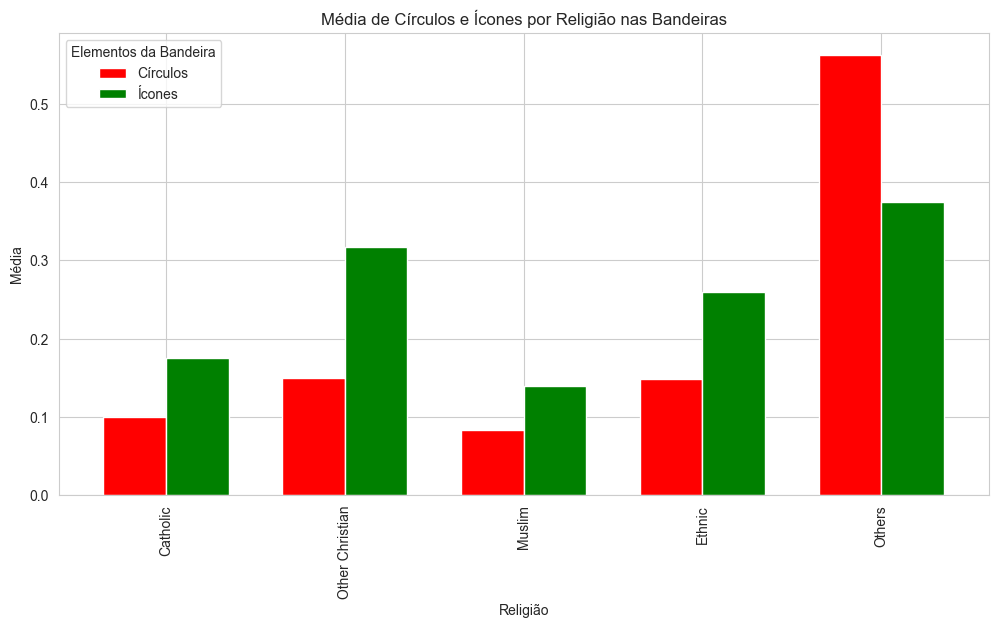

In [453]:
#region 3. Contagem média de círculos e ícones por religião
circleIconReligion = flags.groupby("religion")[["circles", "icon"]].mean()

# Atualizar os índices para exibir os rótulos das religiões
circleIconReligion.index = circleIconReligion.index.map(religionLabels)

plt.figure(figsize=(12, 6), dpi=100)

# Plot da média de círculos e ícones por religião
circleIconReligion.plot(
    kind="bar",
    color="rgb",
    width=0.7,
    ax=plt.gca()
)

plt.title("Média de Círculos e Ícones por Religião nas Bandeiras")
plt.xlabel("Religião")
plt.ylabel("Média")
plt.legend(["Círculos", "Ícones"], title="Elementos da Bandeira")
plt.show()
#endregion

* **Ícone:** 1 se uma imagem inanimada estiver presente (por exemplo, um barco), caso contrário 0.
* **Animar:** 1 se uma imagem animada (por exemplo, uma águia, uma árvore, uma mão humana) estiver presente, 0 caso contrário.
* **Crescente:** 1 se um símbolo de lua crescente estiver presente, caso contrário 0.

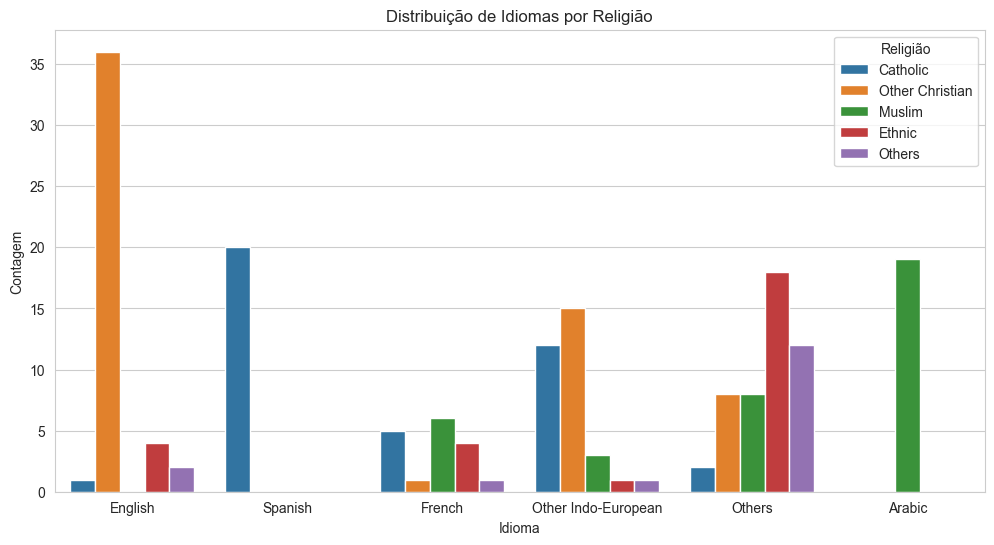

In [454]:
#region 4. Distribuição de idiomas por religião
plt.figure(figsize=(12, 6), dpi=100)
ax = sns.countplot(data=flags, x="language", hue="religion", palette="tab10")
ax.set_xticklabels([languageLabels.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [religionLabels.get(int(label), label) for label in labels], title="Religião")

plt.title("Distribuição de Idiomas por Religião")
plt.xlabel("Idioma")
plt.ylabel("Contagem")
plt.show()
#endregion

In [455]:
contagem = flags.groupby(["language", "religion"]).size().reset_index(name="count")
# contagem

>* **Others:** Além de outras linguagens (desconhecidas), também, inclui os idiomas japonês, turco, finlandês e magiar.

>* **Outras línguas indo-europeias:** Além de outras línguas indo-europeias, inclui o alemão e o eslavo.

**Línguas celtas:**
* Irlandês
* Gaélico escocês
* Galês
* Bretão
* Línguas gregas:

**Línguas indo-arianas (algumas consideradas parte do grupo indo-europeu em sentido amplo):**
* Hindi
* Bengali
* Punjabi
* Gujarati

**Línguas iranianas:**
* Persa (farsi)
* Curdo
* Pashto

> **Proporção de Presença de Cores em Bandeiras por Idioma:** O gráfico de calor mostra a proporção de presença de cores em bandeiras por idioma, destacando as cores mais comuns em cada idioma.

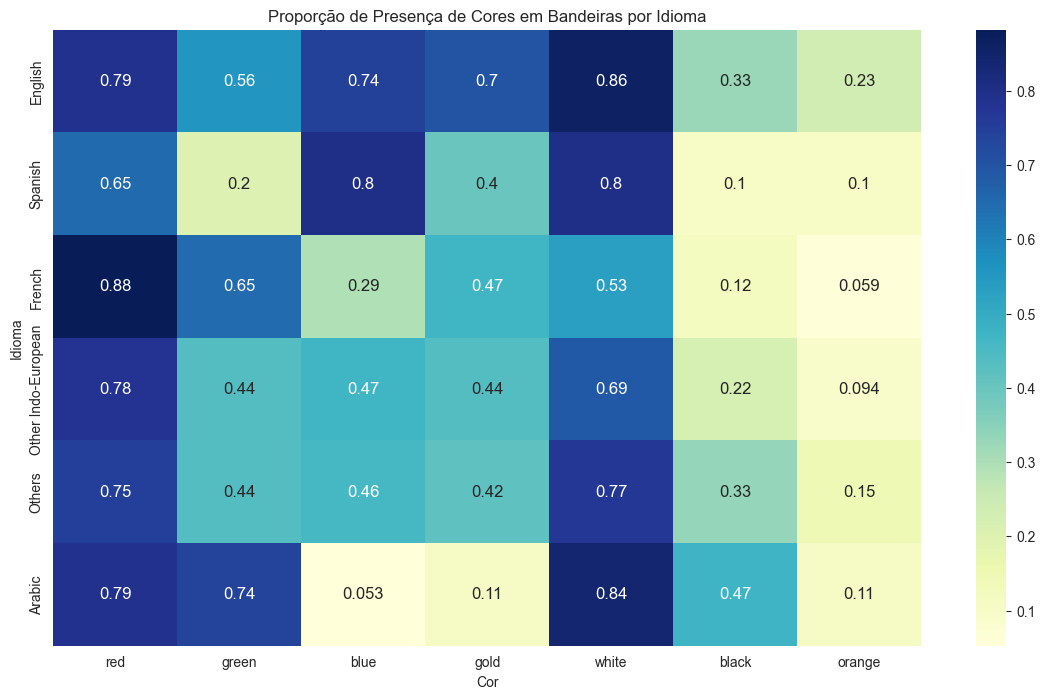

In [456]:
#region 5. Presença de cores nas bandeiras por idioma
flagsColorsLanguage = flags[colors + ["language"]].groupby("language").mean()

plt.figure(figsize=(14, 8), dpi=100)
sns.heatmap(
    flagsColorsLanguage,
    annot=True,
    cmap="YlGnBu",
    cbar=True,
    yticklabels=[languageLabels.get(lang, lang) for lang in flagsColorsLanguage.index],
    annot_kws={"size": 12}
)
plt.title("Proporção de Presença de Cores em Bandeiras por Idioma")
plt.xlabel("Cor")
plt.ylabel("Idioma")
plt.show()
#endregion

## Etapa 4: Rede Neural - Manipulação do Dataset

In [457]:
flagsTest = pd.read_csv("dataset/flags_tratado.csv")

In [458]:
# [0, 1, 2, 3] -> com outliers
# [4, 5, 6, 7] -> sem outliers

setClassificador = 0
file = "sets/classificador-" + str(setClassificador) + ".pth"

### Valores Únicos

In [459]:
#region Identifica as religiões que aparecem apenas uma vez em cada continente
def findOccurrenceReligions(data, continent="landmass", religion="religion"):
    religionContinentCounts = data.groupby([continent, religion]).size().reset_index(name="count")

    singleOccurrenceReligions = religionContinentCounts[religionContinentCounts["count"] == 1]

    return singleOccurrenceReligions

#endregion

In [460]:
single = findOccurrenceReligions(flagsTest)

In [461]:
# Remover as tuplas com religiões únicas
if setClassificador not in range(0, 4):
    flagsTest = flagsTest.drop(index=single.index.to_list())

### Continentes

* 1 = N.America
* 2 = S.America
* 3 = Europe
* 4 = Africa
* 5 = Asia
* 6 = Oceania

In [462]:
#region Mapeamentos para os rótulos de continentes
landmassMapping = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0}

flagsTest["landmass"] = flagsTest["landmass"].replace(landmassMapping)
#endregion

In [463]:
print(flagsTest["landmass"].value_counts())

landmass
0    94
1    85
Name: count, dtype: int64


### Religiões

* 0 = Catholic
* 1 = Other Christian
* 2 = Muslim
* 3 = Buddhist
* 4 = Hindu
* 5 = Ethnic
* 6 = Marxist (Eliminada)
* 7 = Others

In [464]:
#region Mapeamentos para os rótulos de religiões
if setClassificador in [0, 4]:
    # Cristã e Outras (94, 85)
    flagsTest["religion"] = flagsTest["religion"].replace([0, 1], 0)
    flagsTest["religion"] = flagsTest["religion"].replace([2, 3, 4, 5, 6], 1)
    binary = True
elif setClassificador in [1, 5]:
    # Monoteístas, Politeístas e Outras (136, 31, 12)
    flagsTest["religion"] = flagsTest["religion"].replace([0, 1, 2], 0)
    flagsTest["religion"] = flagsTest["religion"].replace([4, 5], 1)
    flagsTest["religion"] = flagsTest["religion"].replace([3, 6], 2)
    binary = False
elif setClassificador in [2, 6]:
    # Ocidental, Oriental e Outras (100, 48, 31)
    flagsTest["religion"] = flagsTest["religion"].replace([0, 1], 0)
    flagsTest["religion"] = flagsTest["religion"].replace([2, 3, 4], 1)
    flagsTest["religion"] = flagsTest["religion"].replace([5, 6], 2)
    binary = False
else:
    # Cristã, Islâmica, Oriental e Outras (98, 35, 30, 11)
    flagsTest["religion"] = flagsTest["religion"].replace([0, 1], 0)
    flagsTest["religion"] = flagsTest["religion"].replace(2, 1)
    flagsTest["religion"] = flagsTest["religion"].replace([3, 4], 2)
    flagsTest["religion"] = flagsTest["religion"].replace([5, 6], 3)
    binary = False
#endregion

### Linguagens

* 1: "English",
* 2: "Spanish",
* 3: "French",
* 4: "German",
* 5: "Slavic",
* 6: "Other Indo-European",
* 7: "Chinese",
* 8: "Arabic",
* 9: "Japanese/Turkish/Finnish/Magyar",
* 10: "Others"

In [465]:
#region Mapeamentos para os rótulos de linguagens
flagsTest["language"] = flagsTest["language"].replace([7, 9], 10)

flagsTest["language"] = flagsTest["language"].replace([4, 5], 6)

languageMapping = {6: 4, 8: 5, 10: 6}

flagsTest["language"] = flagsTest["language"].replace(languageMapping)
#endregion

In [466]:
print(flagsTest["language"].value_counts())

language
6    48
1    43
4    32
2    20
5    19
3    17
Name: count, dtype: int64


### Correlação de Spearman

In [467]:
features = ["landmass", "language", "area", "population", "zone", "religion"]

In [468]:
spearmanTest = flagsTest[features].corr(method="spearman")["religion"].sort_values(ascending=False)
# print(spearmanTest)

## Etapa 5: Rede Neural - Preparação dos Dados

In [469]:
np.random.seed(123)
torch.manual_seed(123)

In [470]:
flagsTest = flagsTest[features]

scaler = MinMaxScaler()

X = scaler.fit_transform(flagsTest.drop(columns="religion", axis=1).values)
y = flagsTest["religion"].values

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [472]:
#region Reajustar o índice "errado"
def fixSample(X_train, X_test, y_train, y_test, indice=31):
    erro_X = X_test[indice].reshape(1, -1)
    erro_y = y_test[indice]

    # Adicionar ao conjunto de treinamento
    X_train = np.vstack([X_train, erro_X])
    y_train = np.append(y_train, erro_y)

    # Remover do conjunto de teste
    X_test = np.delete(X_test, indice, axis=0)
    y_test = np.delete(y_test, indice)

    return X_train, X_test, y_train, y_test

#endregion

In [473]:
X_train, X_test, y_train, y_test = fixSample(X_train, X_test, y_train, y_test)

In [474]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.int64)

In [475]:
X_train.shape, y_train.shape

(torch.Size([144, 5]), torch.Size([144]))

In [476]:
len(np.unique(y))

2

## Etapa 6: Rede Neural - Classe da Rede Neural

In [477]:
#region ClassificadorTorch para Skorch
class ClassificadorTorch(nn.Module):
    def __init__(self, activation, neurons, initializer):
        super().__init__()
        self.dense0 = nn.Linear(X_train.shape[1], neurons)
        initializer(self.dense0.weight)
        self.activation0 = activation
        # ---
        self.dense1 = nn.Linear(neurons, neurons)
        initializer(self.dense1.weight)
        self.activation1 = activation
        # ---
        self.dense2 = nn.Linear(neurons, 1)
        initializer(self.dense2.weight)
        # ---
        self.dropout = nn.Dropout(0.2)

    def forward(self, X):
        X = self.activation0(self.dense0(X))
        X = self.dropout(X)
        # ---
        X = self.activation1(self.dense1(X))
        X = self.dropout(X)
        # ---
        X = self.dense2(X)
        return X

#endregion

## Etapa 7: Rede Neural - Skorch

In [478]:
#region Definição do Classificador
# NeuralNetClassifier, CrossEntropyLoss (criterion) -> multi-class | NeuralNetBinaryClassifier -> single-class
classificador = NeuralNetBinaryClassifier(
    module=ClassificadorTorch,
    criterion=nn.BCEWithLogitsLoss,
    # criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=False,
    verbose=0
)
#endregion

## Etapa 8: Rede Neural - Tuning dos Hiperparâmetros

In [479]:
#region Grid de Hiperparâmetros
def getHyperparameterGrid():
    return {
        "batch_size": [10, 20, 30],
        "max_epochs": [1000, 2000, 3000],
        "module__neurons": [3, 6, 12],
        "module__activation": [F.relu, F.leaky_relu],
        "module__initializer": [nn.init.normal_, nn.init.uniform_],
    }

#endregion

In [480]:
#region Otimização dos Hiperparâmetros
def optimizeHyperparameters(X_train, y_train):
    params = getHyperparameterGrid()
    grid = GridSearchCV(
        estimator=classificador,
        param_grid=params,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    return grid.best_score_, grid.best_params_

#endregion

In [481]:
# acurracy, bestParamns = optimizeHyperparameters(X_train, y_train)

# print(f"Acurácia: {acurracy * 100:.2f}%")
# print(f"Melhores Parâmetros: {bestParamns}")

**Resultados:**
***
**Classes: 0 = Cristã, 1 = Outras**
***
* Acurácia: 92.24% / 91.43% **(- tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 20, 'max_epochs': 2000, 'module__activation': <function leaky_relu at 0x000001A50C98D8A0>, 'module__initializer': <function normal_ at 0x000001A50CA0DD00>, 'module__neurons': 3}
***
* Acurácia: 94.97% / 97.22%  **(+ tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 10, 'max_epochs': 1000, 'module__activation': <function leaky_relu at 0x000001A50C98D8A0>, 'module__initializer': <function normal_ at 0x000001A50CA0DD00>, 'module__neurons': 6}**
***
**Classes: 0 = Monoteístas, 1 = Politeístas e 2 = Outras**
***
* Acurácia: 82.56% / 77.14% **(- tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 10, 'max_epochs': 2000, 'module__activation': <function relu at 0x0000024145CE3060>, 'module__initializer': <function normal_ at 0x0000024145D53920>, 'module__neurons': 8}
***
* Acurácia: 85.58% / 80.56% **(+ tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 10, 'max_epochs': 1000, 'module__activation': <function leaky_relu at 0x000001A50C98D8A0>, 'module__initializer': <function uniform_ at 0x000001A50CA0DC60>, 'module__neurons': 16}
***
**Classes: 0 = Ocidental, 1 = Oriental e 2 = Outras**
***
* Acurácia: 83.10% / 77.14% **(- tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 20, 'max_epochs': 3000, 'module__activation': <function relu at 0x000001A50C98D440>, 'module__initializer': <function uniform_ at 0x000001A50CA0DC60>, 'module__neurons': 8}
***
* Acurácia: 84.18% / 83.33% **(+ tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 30, 'max_epochs': 2000, 'module__activation': <function relu at 0x000001A50C98D440>, 'module__initializer': <function normal_ at 0x000001A50CA0DD00>, 'module__neurons': 16}
***
**Classes: 0 = Cristã, 1 = Islâmica, 2 = Oriental e 3 = Outras**
***
* Acurácia: 81.75% / 74.29% **(- tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 10, 'max_epochs': 3000, 'module__activation': <function leaky_relu at 0x0000024145CE34C0>, 'module__initializer': <function normal_ at 0x0000024145D53920>, 'module__neurons': 10}
***
* Acurácia: 78.44% / 75.00% **(+ tuplas | - linguagens | - continentes)**
* Melhores Parâmetros: {'batch_size': 20, 'max_epochs': 2000, 'module__activation': <function relu at 0x0000024145CE3060>, 'module__initializer': <function uniform_ at 0x0000024145D53880>, 'module__neurons': 20}

## Etapa 9: Rede Neural - Transformação dos Dados em Tensores

In [482]:
#region Inicialização dos Pesos
normal_ = lambda weight: nn.init.normal_(weight, mean=0.0, std=0.05)

params = [
    # Com outliers
    {'batch_size': 10, 'max_epochs': 1000, 'module__activation': nn.LeakyReLU(), 'module__initializer': normal_,
     'module__neurons': 6},
    {'batch_size': 10, 'max_epochs': 1000, 'module__activation': nn.LeakyReLU(),
     'module__initializer': nn.init.uniform_, 'module__neurons': 16},  # 3
    {'batch_size': 30, 'max_epochs': 2000, 'module__activation': nn.ReLU(), 'module__initializer': normal_,
     'module__neurons': 16},
    {'batch_size': 20, 'max_epochs': 2000, 'module__activation': nn.ReLU(), 'module__initializer': nn.init.uniform_,
     'module__neurons': 20},

    # Sem outliers
    {'batch_size': 20, 'max_epochs': 2000, 'module__activation': nn.LeakyReLU(), 'module__initializer': normal_,
     'module__neurons': 3},
    {'batch_size': 10, 'max_epochs': 2000, 'module__activation': nn.ReLU(), 'module__initializer': normal_,
     'module__neurons': 8},
    {'batch_size': 20, 'max_epochs': 3000, 'module__activation': nn.ReLU(), 'module__initializer': nn.init.uniform_,
     'module__neurons': 8},
    {'batch_size': 10, 'max_epochs': 3000, 'module__activation': nn.LeakyReLU(), 'module__initializer': normal_,
     'module__neurons': 10},
]
#endregion

In [483]:
#region Inicialização dos parâmetros
config = params[setClassificador]

batch = config["batch_size"]
epochs = config["max_epochs"]
activation = config["module__activation"]
initializer = config["module__initializer"]
neurons = config["module__neurons"]

saida = 1 if binary else len(np.unique(y))
#endregion

In [484]:
typed = torch.float32 if binary else torch.int64

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=typed)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=typed)

In [485]:
trainDataset = torch.utils.flagsPopulationByCluster.TensorDataset(X_train, y_train)
train_loader = torch.utils.flagsPopulationByCluster.DataLoader(trainDataset, batch_size=batch, shuffle=True)

In [486]:
testDataset = torch.utils.flagsPopulationByCluster.TensorDataset(X_test, y_test)
test_loader = torch.utils.flagsPopulationByCluster.DataLoader(testDataset, batch_size=batch, shuffle=False)

## Etapa 10: Rede Neural - Construção do Modelo

In [487]:
#region Classificador do Modelo
class ClassificadorTorch(nn.Module):
    def __init__(self, neurons, activation, initializer, saida):
        super(ClassificadorTorch, self).__init__()

        self.dense0 = nn.Linear(X_train.shape[1], neurons)
        initializer(self.dense0.weight)
        # *************************************************** #
        self.dense1 = nn.Linear(neurons, neurons)
        initializer(self.dense1.weight)
        # *************************************************** #
        self.dense2 = nn.Linear(neurons, saida)
        # *************************************************** #
        self.activation = activation
        # *************************************************** #
        self.dropout = nn.Dropout(0.2)

    def forward(self, X):
        X = self.activation(self.dense0(X))
        X = self.dropout(X)
        # *************************************************** #
        X = self.activation(self.dense1(X))
        X = self.dropout(X)
        # *************************************************** #
        X = self.dense2(X)
        return X

#endregion

In [488]:
classificador = ClassificadorTorch(neurons=neurons, activation=activation, initializer=initializer, saida=saida)

In [489]:
criterion = nn.BCEWithLogitsLoss() if binary else nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    classificador.parameters(),
    lr=0.01,
    weight_decay=0.0001
)

## Etapa 11: Rede Neural - Treinamento do Modelo

In [490]:
epochsList = []
lossList = []
accuracyList = []

In [491]:
#region Treinamento do Modelo (Binário)
def trainBinary():
    for epoch in range(epochs):
        # Colocar em modo de treinamento
        classificador.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for data in train_loader:
            inputs, labels = data
            # Ajuste para BCEWithLogitsLoss
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = classificador(inputs)

            # Calcula a perda
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Atualiza o loss e a acurácia
            running_loss += loss.item()
            # Converte as saídas para 0 ou 1
            predictions = (outputs >= 0.5).float()
            running_accuracy += (predictions == labels).float().mean().item()

        epochsList.append(epoch)
        lossList.append(running_loss / len(train_loader))
        accuracyList.append(running_accuracy / len(train_loader))

        # Impressão dos resultados a cada 100 épocas
        if epoch % 100 == 0:
            print(
                f"Época {epoch} - Loss: {running_loss / len(train_loader):.4f} - Acurácia: {running_accuracy / len(train_loader) * 100:.2f}%")

#endregion

In [492]:
#region Treinamento do Modelo (Multi)
def trainMulti():
    for epoch in range(epochs):
        # Colocar em modo de treinamento
        classificador.train()
        running_loss = 0.
        running_accuracy = 0.

        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()

            outputs = classificador(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_accuracy += (outputs.argmax(1) == labels).float().mean().item()

        epochsList.append(epoch)
        lossList.append(running_loss / len(train_loader))
        accuracyList.append(running_accuracy / len(train_loader))

        if epoch % 100 == 0:
            print(
                f"Epoch {epoch} - Loss: {running_loss / len(train_loader):.4f} - Accuracy: {running_accuracy / len(train_loader):.4f}")

#endregion

In [493]:
if not os.path.exists(file):
    trainBinary() if binary else trainMulti()

    averageAccuracy = sum(accuracyList) / len(accuracyList)
    print(f"\nAcurácia Média Final: {averageAccuracy * 100:.2f}%")

## Etapa 12: Rede Neural - Salvar o Classificador

In [494]:
if not os.path.exists(file):
    torch.save(classificador.state_dict(), file)

## Etapa 13: Rede Neural - Carregar o Classificador

In [495]:
classificador = ClassificadorTorch(neurons=neurons, activation=activation, initializer=initializer, saida=saida)

In [496]:
classificador.load_state_dict(torch.load(file))

<All keys matched successfully>

## Etapa 14: Rede Neural - Teste do Modelo

In [497]:
classificador.eval()

ClassificadorTorch(
  (dense0): Linear(in_features=5, out_features=6, bias=True)
  (dense1): Linear(in_features=6, out_features=6, bias=True)
  (dense2): Linear(in_features=6, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [498]:
allPreds = []
allLabels = []

In [499]:
#region Teste do Modelo (Binario)
def testBinary():
    # torch.no_grad() -> Desativar o cálculo de gradientes para avaliação
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = classificador(inputs)

            # Remove dimensões extras para compatibilidade
            preds = (outputs >= 0.5).float().squeeze()
            allPreds.extend(preds.numpy())
            allLabels.extend(labels.numpy())

#endregion

In [500]:
#region Teste do Modelo (Multi)
def testMulti():
    # torch.no_grad() -> Desativar o cálculo de gradientes para avaliação
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            outputs = classificador(test_inputs)
            # Obter a classe prevista
            preds = outputs.argmax(dim=1)
            # Adicionar previsões à lista
            allPreds.extend(preds.tolist())
            # Adicionar rótulos verdadeiros à lista
            allLabels.extend(test_labels.tolist())

#endregion

In [501]:
testBinary() if binary else testMulti()

In [502]:
accuracy = accuracy_score(allLabels, allPreds)
cm = confusion_matrix(allLabels, allPreds)
cr = classification_report(allLabels, allPreds)

In [503]:
print(f"Acurácia: {accuracy * 100:.2f}%\n")

Acurácia: 100.00%



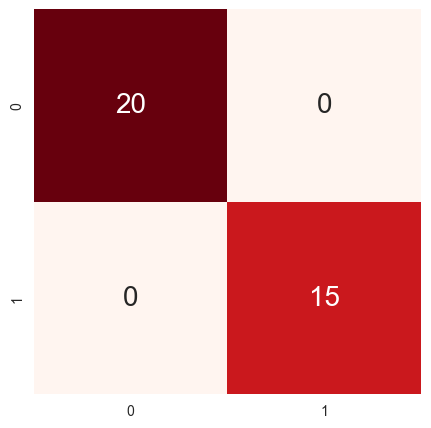

In [504]:
#region Plot Matriz de Confusão
plt.figure(figsize=(5, 5), dpi=100)

sns.heatmap(
    cm,
    annot=True,
    cmap="Reds",
    cbar=False,
    fmt="d",
    annot_kws={"size": 20}
);
#endregion

In [505]:
print(f"Relatório de Classificação:\n {cr}\n")

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35




In [506]:
#region Identifica os Falsos Negativos
allPreds = np.array(allPreds)
allLabels = np.array(allLabels)
indices = np.arange(len(allLabels))

falsosNegativos = indices[(allLabels == 1) & (allPreds == 0)]

if len(falsosNegativos) > 0:
    print(f"Índices dos 5 primeiros registros classificados como falsos negativos: {falsosNegativos}\n")

    print(flagsTest.iloc[falsosNegativos])
#endregion

## Etapa 15: Rede Neural - Curva ROC

In [507]:
#region Curva ROC Multi
def curveROCMulti():
    with torch.no_grad():
        predProb = classificador(X_test)

        # Aplica Sigmoid caso não tenha usado BCEWithLogitsLoss na saída
        if not isinstance(criterion, torch.nn.BCEWithLogitsLoss):
            predProb = torch.sigmoid(predProb)

        # Converte para numpy para usar com sklearn
        predProb = predProb.numpy()

    # Binarizar y_test para o caso multiclasse
    testBinarized = label_binarize(y_test, classes=np.arange(saida))

    # Calcula a curva ROC para cada classe
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(saida):
        fpr[i], tpr[i], _ = roc_curve(testBinarized[:, i], predProb[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotar a curva ROC para cada classe
    plt.figure(figsize=(12, 8), dpi=100)
    for i in range(saida):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC Multiclasse')
    plt.legend(loc="lower right")
    plt.show()

#endregion

In [508]:
#region Curva ROC Binary
def curveROCBinary():
    with torch.no_grad():
        predProb = classificador(X_test)

        # Aplica Sigmoid caso não tenha usado BCEWithLogitsLoss na saída
        if not isinstance(criterion, torch.nn.BCEWithLogitsLoss):
            predProb = torch.sigmoid(predProb)

        # Converte para numpy para usar com sklearn
        predProb = predProb.numpy()

        # Calcula as taxas de verdadeiro positivo e falso positivo
        fpr, tpr, _ = roc_curve(y_test, predProb)

    rocAUC = auc(fpr, tpr)

    plt.figure(figsize=(12, 8), dpi=100)

    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {rocAUC:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")

    plt.show()

#endregion

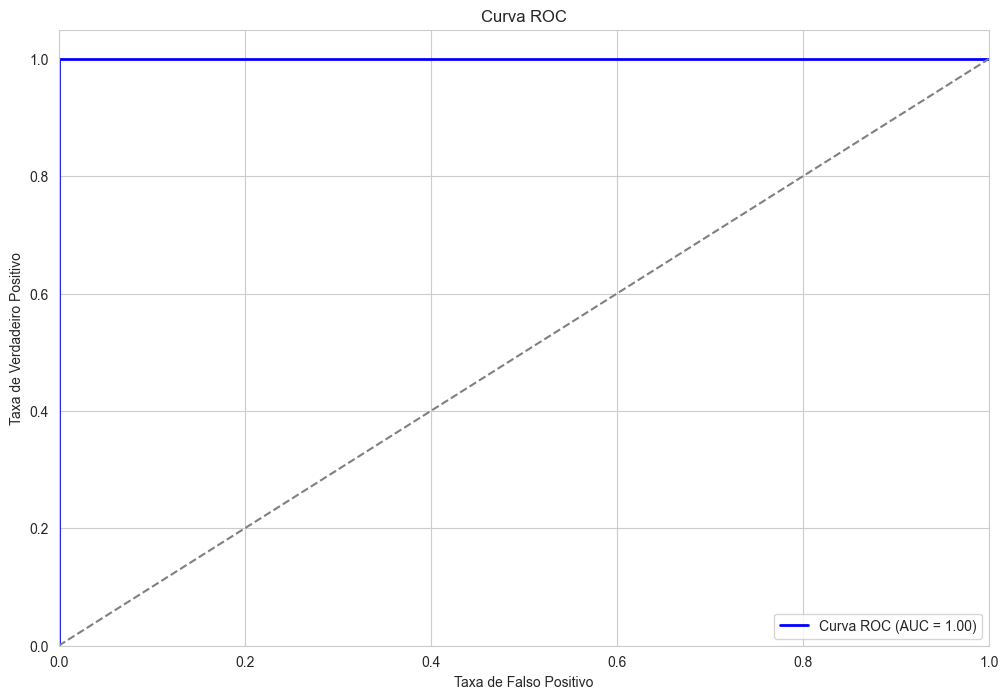

In [509]:
curveROCBinary() if binary else curveROCMulti()